In [2]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder

from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

import scipy.stats

# Single Lag

In [3]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"

dataset_5ms = NWBDataset(filename, split_heldout=False)
xy_vel = dataset_5ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_5ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])

dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [4]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

218 trials
153 neurons
(558262, 153)
(558262, 153)
(558262, 20)
PCA total var explained: 0.3878935783429342


In [5]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only 0 will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [6]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()
    lr_all.fit(rates_array, vel_array)
    pred_vel = lr_all.predict(rates_array)
    vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    
    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, 2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,n_trials)):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    
    sses =get_sses_pred(true_concat[:,0],pred_concat[:,0])
    sses_mean=get_sses_mean(true_concat[:,0])
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('x-vel R2:',R2) 
    
    sses =get_sses_pred(true_concat[:,1],pred_concat[:,1])
    sses_mean=get_sses_mean(true_concat[:,1])
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('y-vel R2:',R2) 
    
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_, vel_df

In [7]:
def pred_with_new_weights(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, sub_weights):
    
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)

    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()
    
    pred_vel = np.dot(rates_array,sub_weights.T)
    
    print(pred_vel.shape)
    
    sses =get_sses_pred(vel_array[:,0],pred_vel[:,0])
    sses_mean=get_sses_mean(vel_array[:,0])
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('x-vel R2:',R2) 
    
    sses =get_sses_pred(vel_array[:,1],pred_vel[:,1])
    sses_mean=get_sses_mean(vel_array[:,1])
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('y-vel R2:',R2) 
    
    sses =get_sses_pred(vel_array,pred_vel)
    sses_mean=get_sses_mean(vel_array)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    
    r = scipy.stats.pearsonr(vel_array.reshape(-1), pred_vel.reshape(-1))[0]
    
    vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    
    return R2, r, vel_df

## with Neurons

In [18]:
positive_lag = 100
negative_lag = -100
x_field = 'spikes_smth_40'
y_field ='hand_acc'

# Prepare for plotting
plot_dir = [0.0,90.0, 180.0,270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red','blue', 'green','orange']
figDir = "/Users/sherryan/area2_population_analysis/figures/neurons/act-pas/"

dataset = dataset_5ms

x-vel R2: 0.5372183393205534
y-vel R2: 0.7026714731539263
R2: 0.6489051697428512
x-vel R2: 0.7157510040879175
y-vel R2: 0.425604009675298
R2: 0.5198913221846602
(29400, 2)
x-vel R2: 0.3750521154355906
y-vel R2: 0.5577212810307899
R2: 0.46151478503789567
(29400, 2)
x-vel R2: 0.2794710366283957
y-vel R2: 0.26167268779855335
R2: 0.2710465565070428


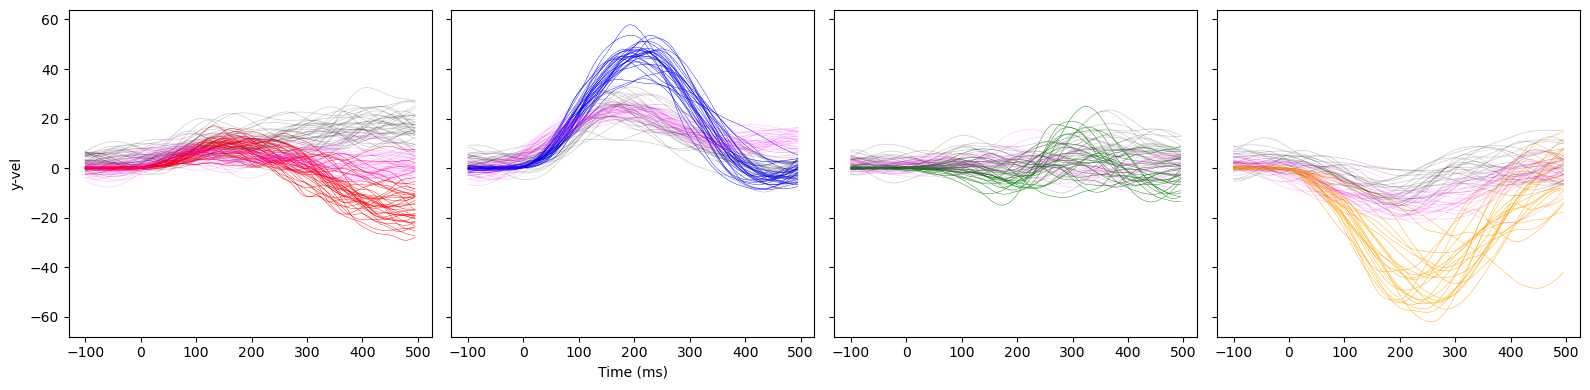

In [ ]:
# # Efference copy strength over time (in active)

# plot_dim = 'y'
# y_field ='hand_vel'
# fit_range = (0,120)
# pred_range = (-100,500)
# x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

# _, aff_weights, _ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, positive_lag, x_field, y_field)
# _, eff_weights, _ = fit_and_predict(dataset, active_mask, 'move_onset_time', fit_range, negative_lag, x_field, y_field)
# _, _, aff_vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, positive_lag,x_field,y_field, aff_weights)
# _, _, eff_vel_df = pred_with_new_weights(dataset, active_mask, 'move_onset_time',pred_range, negative_lag,x_field,y_field, eff_weights)


# fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
# i = 0
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in eff_vel_df[np.isin(eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         axs[i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.3)
#         axs[i].plot(x_axis, trial.pred_vel[plot_dim], color='k', alpha = 0.2, linewidth=0.5)
#     for _, trial in aff_vel_df[np.isin(aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         axs[i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.2, linewidth=0.5)
    
#     i+=1
# axs[1].set_xlabel('Time (ms)')
# axs[0].set_ylabel('y-vel')
# plt.tight_layout()


x-vel R2: 0.827927763523767
y-vel R2: 0.7690290914403621
R2: 0.8000752878358859
x-vel R2: 0.8409186046013313
y-vel R2: 0.7289083965706604
R2: 0.7879503205023143


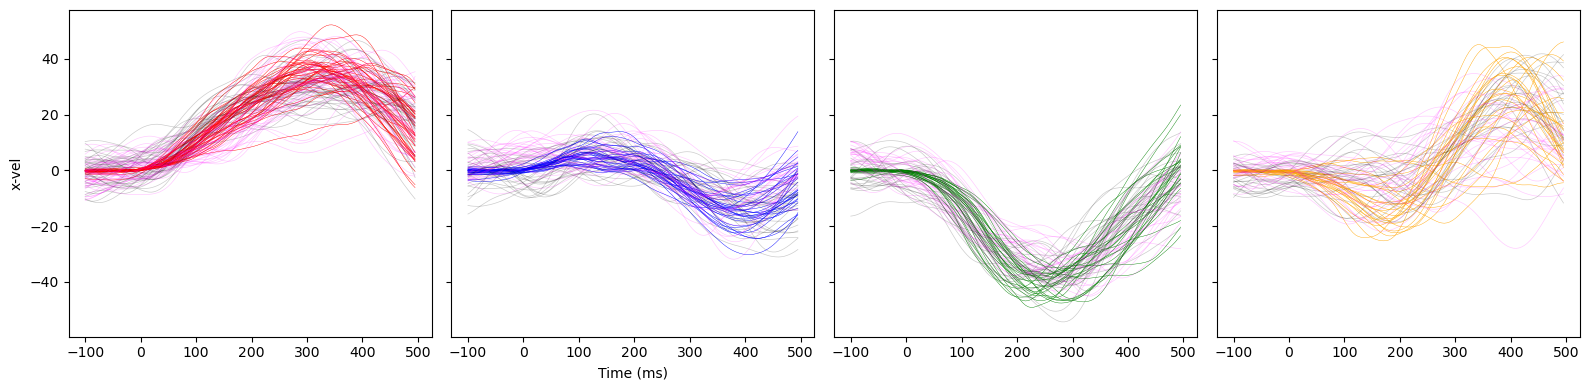

In [ ]:
# # Efference copy strength over time (in active)

# plot_dim = 'x'
# y_field ='hand_vel'
# pred_range = (-100,500)
# x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)

# _, _, aff_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, positive_lag, x_field, y_field)
# _, _, eff_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, negative_lag, x_field, y_field)


# fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
# i = 0
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset_5ms.trial_info[dataset_5ms.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in eff_vel_df[np.isin(eff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         axs[i].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.3)
#         axs[i].plot(x_axis, trial.pred_vel[plot_dim], color='k', alpha = 0.2, linewidth=0.5)
#     for _, trial in aff_vel_df[np.isin(aff_vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         axs[i].plot(x_axis, trial.pred_vel[plot_dim], color='magenta', alpha = 0.2, linewidth=0.5)
    
#     i+=1
# axs[1].set_xlabel('Time (ms)')
# axs[0].set_ylabel('x-vel')
# plt.tight_layout()


In [19]:
ranges = [(0,120),(-100,120)]
labels = ['early_acc_','long_acc_']
for pred_range, label in zip(ranges,labels):
    lag = positive_lag
    actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    actOnPas_R2, actOnPas_r, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

    x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
    # Loop through trials, plotting true and predicted velocities on appropriate subplot
    handles = []; labels = []
    for trial_dir, color in zip(plot_dir, colors):
        cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
        for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            hdl = axs[0][0].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][1].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][2].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        handles.append(hdl[0])
        labels.append(trial_dir)

    # Add labels
    axs[0][0].set_title('Active trials')
    axs[0][1].set_title('Passive trials')
    axs[0][2].set_title('Active weights on Passive trials')

    axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
    axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
    axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000) + ', r: ' + str(int(actOnPas_r*1000)/1000))


    axs[0][0].set_ylabel(f'True {plot_dim} {y_field}')
    axs[1][0].set_ylabel(f'Predicted {plot_dim} {y_field}')
    axs[1][0].set_xlabel('Time after move onset (ms)')
    axs[1][1].set_xlabel('Time after arm bump (ms)')
    axs[1][2].set_xlabel('Time after arm bump (ms)')
    axs[0][0].set_xlim(pred_range)
    fig.suptitle('Predicting ' + str(y_field)+ ', Positive Lag')
    fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
    plt.tight_layout()
    plt.savefig(figDir + monkey + '_pos_' + label + plot_dim +'.png', dpi = 'figure')
    plt.close()

    lag = negative_lag
    actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field)
    pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    actOnPas_R2, actOnPas_r, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
    # Loop through trials, plotting true and predicted velocities on appropriate subplot
    handles = []; labels = []
    for trial_dir, color in zip(plot_dir, colors):
        cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
        for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            hdl = axs[0][0].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][1].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][2].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        handles.append(hdl[0])
        labels.append(trial_dir)

    # Add labels
    axs[0][0].set_title('Active trials')
    axs[0][1].set_title('Passive trials')
    axs[0][2].set_title('Active weights on Passive trials')

    axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
    axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
    axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000) + ', r: ' + str(int(actOnPas_r*1000)/1000))


    axs[0][0].set_ylabel(f'True {plot_dim} {y_field}')
    axs[1][0].set_ylabel(f'Predicted {plot_dim} {y_field}')
    axs[1][0].set_xlabel('Time after move onset (ms)')
    axs[1][1].set_xlabel('Time after arm bump (ms)')
    axs[1][2].set_xlabel('Time after arm bump (ms)')
    axs[0][0].set_xlim(pred_range)
    fig.suptitle('Predicting ' + str(y_field)+ ', Negative Lag')
    fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
    plt.tight_layout()
    plt.savefig(figDir + monkey + '_neg_' + label + plot_dim +'.png', dpi = 'figure')
    plt.close()

x-vel R2: 0.6702815983366679
y-vel R2: 0.7728661419514115
R2: 0.7393713627476052
x-vel R2: 0.8020731424301347
y-vel R2: 0.5237636084658854
R2: 0.7199564239940925
(5232, 2)
x-vel R2: 0.5525898391866071
y-vel R2: 0.4284633107061022
R2: 0.5158835644405481
x-vel R2: 0.6506320614537693
y-vel R2: 0.20116508427572333
R2: 0.34792010827348463
x-vel R2: -0.35757110759099486
y-vel R2: -0.5217886329920209
R2: -0.4060243678998967
(5232, 2)
x-vel R2: -0.0927106743851529
y-vel R2: -0.2864029750415029
R2: -0.14998870262876696
x-vel R2: 0.6078309228717356
y-vel R2: 0.739114264096959
R2: 0.6970890489623921
x-vel R2: 0.6957231684291036
y-vel R2: 0.38618150970562226
R2: 0.6020799664949149
(9592, 2)
x-vel R2: 0.4376274367188808
y-vel R2: 0.035077524662193826
R2: 0.315685411030163
x-vel R2: 0.5828552133192522
y-vel R2: 0.2183640534481308
R2: 0.3350416095285558
x-vel R2: -0.19174822112319223
y-vel R2: -0.26459134462411593
R2: -0.2137848780037077
(9592, 2)
x-vel R2: -0.14739616863279825
y-vel R2: -0.323116176

## with PCA

In [20]:
positive_lag = 100
negative_lag = -100
x_field = 'PCA'
y_field ='hand_acc'

# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
colors = ['red', 'blue', 'green', 'orange']
figDir = "/Users/sherryan/area2_population_analysis/figures/PCA/act-pas/"
dataset = dataset_5ms

In [21]:
ranges = [(0,120),(-100,120)]
labels = ['early_acc_','long_acc_']
for pred_range, label in zip(ranges,labels):
    lag = positive_lag
    actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    actOnPas_R2, actOnPas_r, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

    x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
    # Loop through trials, plotting true and predicted velocities on appropriate subplot
    handles = []; labels = []
    for trial_dir, color in zip(plot_dir, colors):
        cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
        for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            hdl = axs[0][0].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][1].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][2].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        handles.append(hdl[0])
        labels.append(trial_dir)

    # Add labels
    axs[0][0].set_title('Active trials')
    axs[0][1].set_title('Passive trials')
    axs[0][2].set_title('Active weights on Passive trials')

    axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
    axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
    axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000) + ', r: ' + str(int(actOnPas_r*1000)/1000))


    axs[0][0].set_ylabel(f'True {plot_dim} {y_field}')
    axs[1][0].set_ylabel(f'Predicted {plot_dim} {y_field}')
    axs[1][0].set_xlabel('Time after move onset (ms)')
    axs[1][1].set_xlabel('Time after arm bump (ms)')
    axs[1][2].set_xlabel('Time after arm bump (ms)')
    axs[0][0].set_xlim(pred_range)
    fig.suptitle('Predicting ' + str(y_field)+ ', Positive Lag')
    fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
    plt.tight_layout()
    plt.savefig(figDir + monkey + '_pos_' + label + plot_dim +'.png', dpi = 'figure')
    plt.close()

    lag = negative_lag
    actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field)
    pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
    actOnPas_R2, actOnPas_r, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
    # Loop through trials, plotting true and predicted velocities on appropriate subplot
    handles = []; labels = []
    for trial_dir, color in zip(plot_dir, colors):
        cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
        for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            hdl = axs[0][0].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][1].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
            axs[0][2].plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
            axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
        handles.append(hdl[0])
        labels.append(trial_dir)

    # Add labels
    axs[0][0].set_title('Active trials')
    axs[0][1].set_title('Passive trials')
    axs[0][2].set_title('Active weights on Passive trials')

    axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
    axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
    axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000) + ', r: ' + str(int(actOnPas_r*1000)/1000))


    axs[0][0].set_ylabel(f'True {plot_dim} {y_field}')
    axs[1][0].set_ylabel(f'Predicted {plot_dim} {y_field}')
    axs[1][0].set_xlabel('Time after move onset (ms)')
    axs[1][1].set_xlabel('Time after arm bump (ms)')
    axs[1][2].set_xlabel('Time after arm bump (ms)')
    axs[0][0].set_xlim(pred_range)
    fig.suptitle('Predicting ' + str(y_field)+ ', Negative Lag')
    fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
    plt.tight_layout()
    plt.savefig(figDir + monkey + '_neg_' + label + plot_dim +'.png', dpi = 'figure')
    plt.close()

x-vel R2: 0.7294859089081787
y-vel R2: 0.7866288109977388
R2: 0.7679711378131454
x-vel R2: 0.848077394094582
y-vel R2: 0.604145290967796
R2: 0.7761039207296816
(5232, 2)
x-vel R2: 0.6254138988685645
y-vel R2: 0.45311238839277523
R2: 0.5744614823295119
x-vel R2: 0.7111751367645724
y-vel R2: 0.2502428158425176
R2: 0.40074137803491394
x-vel R2: 0.001181805835690164
y-vel R2: -0.036042845921121947
R2: -0.00980152701551984
(5232, 2)
x-vel R2: -0.07702929027400263
y-vel R2: -0.3472873445483837
R2: -0.15694908271457497
x-vel R2: 0.638353420471361
y-vel R2: 0.7238710645868254
R2: 0.6964959432788733
x-vel R2: 0.6940709959454694
y-vel R2: 0.35240292124829165
R2: 0.5907088422202599
(9592, 2)
x-vel R2: 0.40644112084217876
y-vel R2: -0.14989577088061345
R2: 0.23791332960399125
x-vel R2: 0.6091744513829729
y-vel R2: 0.19606082845907868
R2: 0.3283029599920714
x-vel R2: 0.002582103521653556
y-vel R2: -0.015037306660796279
R2: -0.002748157976852905
(9592, 2)
x-vel R2: -0.0788293565088325
y-vel R2: -0.2